### Data Mining and Machine Learning
### Recommendation system using Deep Learning
### Edgar Acuna
### March 2022
#### Using deep Learning neural to create a book recommendation system based on a database of 10000 books and  the ratings of 53424   users.
#### Based on https://towardsdatascience.com/building-a-book-recommendation-system-using-keras-1fba34180699

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [40]:
dataset = pd.read_csv('https://academic.uprm.edu/eacuna/books_ratings.csv')
dataset.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [41]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
n_users = len(dataset.user_id.unique())
n_books = len(dataset.book_id.unique())
print('number of users:',n_users,"number of books:",n_books)

number of users: 53424 number of books: 10000


In [42]:
#Building the model
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
model = Model([user_input, book_input], prod)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Book-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
User-Input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Book-Embedding (Embedding)      (None, 1, 5)         50005       Book-Input[0][0]                 
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         267125      User-Input[0][0]                 
_______________________________________________________________________________________

In [43]:
#Training the model using only 5 epochs
model.compile('adam', 'mean_squared_error')
history = model.fit([train.user_id, train.book_id], train.rating, epochs=5, verbose=1)
model.save('regression_model.h5')

Epoch 1/5
24544/24544 [==============================] - 77s 3ms/step - loss: 13.6752
Epoch 2/5
24544/24544 [==============================] - 76s 3ms/step - loss: 4.1687
Epoch 3/5
24544/24544 [==============================] - 75s 3ms/step - loss: 1.6713
Epoch 4/5
24544/24544 [==============================] - 83s 3ms/step - loss: 1.1485
Epoch 5/5
24544/24544 [==============================] - 83s 3ms/step - loss: 0.9421: 0s


In [44]:
# Extract embeddings
book_em = model.get_layer('Book-Embedding')
book_em_weights = book_em.get_weights()[0]
book_em_weights

array([[ 0.04523328,  0.00722281, -0.04482222, -0.01754832,  0.00818286],
       [-1.0003412 ,  1.1810007 , -1.5369204 ,  1.3970579 ,  0.9313939 ],
       [-1.1085268 ,  1.1728994 , -1.3530923 ,  1.1665043 ,  1.1598928 ],
       ...,
       [-1.8095888 ,  1.8276571 , -1.6301672 ,  1.7134354 , -1.5203803 ],
       [-1.3914104 ,  1.5854274 , -1.4894118 ,  1.4721437 , -1.3917546 ],
       [-1.4675261 ,  1.7549343 , -1.2633133 ,  1.8166945 , -1.6687417 ]],
      dtype=float32)

### Visualizing the embeddings using PCA

<AxesSubplot:>

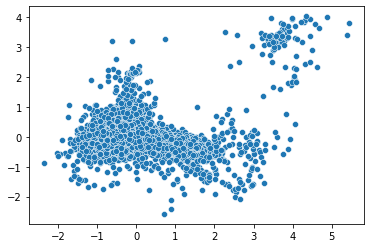

In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as pyplt
import seaborn as sns
%matplotlib inline
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

### Visualizing the embeddings using TSNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.017s...
[t-SNE] Computed neighbors for 10001 samples in 0.573s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.102602
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.457603
[t-SNE] KL

<AxesSubplot:>

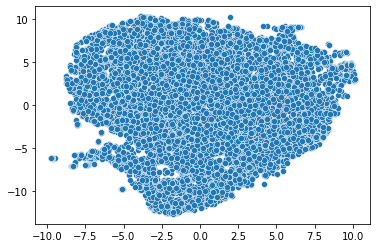

In [46]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_em_weights)
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

#### Creating dataset for making recommendations for the first user

In [47]:
# Creating dataset for making recommendations for the first user
import numpy as np
book_data = np.array(list(set(dataset.book_id)))
user = np.array([1 for i in range(len(book_data))])
predictions = model.predict([user, book_data])
predictions = np.array([a[0] for a in predictions])
recommended_book_ids = (-predictions).argsort()[:5]
#showing the top-5 recommended books
print(recommended_book_ids)

[7843 7660 9208 8232 9517]


In [48]:
#Ratings for the recommended books
print(predictions[recommended_book_ids])

[4.277794  4.255879  4.2363887 4.218408  4.203046 ]


In [49]:
books = pd.read_csv('https://academic.uprm.edu/eacuna/books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [50]:
print(books[books['id'].isin(recommended_book_ids)])

        id   book_id  best_book_id   work_id  books_count        isbn  \
7659  7660     21330         21330      2910           15  1401204864   
7842  7843  17182421      17182421  21762912           49   778315339   
8231  8232     10395         10395     13106           31    60731427   
9207  9208  22040598      22040598  41363353           18  1596435739   
9516  9517     17810         17810    856346           39         NaN   

            isbn13                                            authors  \
7659  9.781401e+12  Bill Willingham, Mark Buckingham, Steve Leialo...   
7842  9.780778e+12                                         Jason Mott   
8231  9.780061e+12                                      Franklin Foer   
9207  9.781596e+12                                      Scott McCloud   
9516  9.780143e+12                       Ryū Murakami, Ralph McCarthy   

      original_publication_year  \
7659                     2005.0   
7842                     2013.0   
8231             